In [144]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import emcee, corner

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

# Colors
import seaborn as sns

In [104]:
label_vshift = '$\Delta v$ [km/s]'
label_vpeak  = '$v_{peak}$ [km/s]'
label_FWHM   = 'FWHM [km/s]'

# Find data

In [18]:
datadir = os.environ['LYA_DATA_DIR']+'data/lya_lineshapes/FWHM_vs_vpeak/z6.0/'

files = reionizer.insensitive_glob(datadir+'*.dat')

# Load file

In [54]:
def load_file_from_Max(filename):
    
    vshift = float(filename.split('.dat')[0].split('vshift')[-1])
    
    tab = pd.read_csv(filename, delim_whitespace=True, 
                      skiprows=1, header=None, names=['N_HI', 'vpeak', 'FWHM'])
    
    return vshift, tab

## Get data into long arrays

Text(0, 0.5, 'FWHM [km/s]')

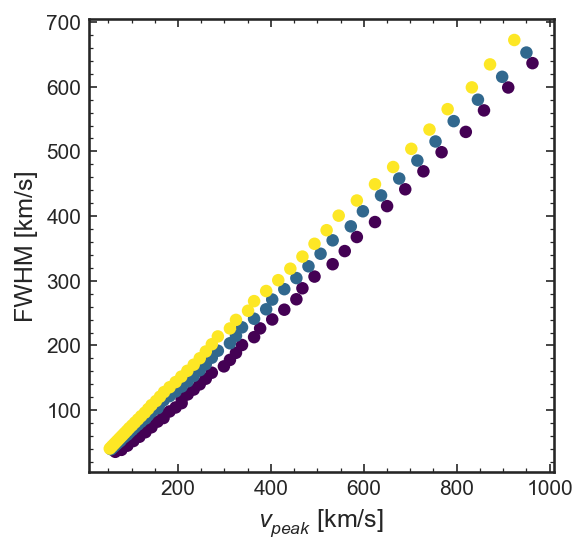

In [142]:
vshift_all = []
vpeak_all  = []
FWHM_all   = []

for f in files:
    vshift, tab = load_file_from_Max(f)
    vshift_all.append(vshift*np.ones(len(tab)))
    vpeak_all.append(tab.vpeak)
    FWHM_all.append(tab.FWHM)
    
vshift_all = np.array(vshift_all).ravel()
vpeak_all  = np.array(vpeak_all).ravel()
FWHM_all   = np.array(FWHM_all).ravel()

plt.figure(figsize=(4,4), dpi=150)
plt.scatter(vpeak_all, FWHM_all, c=vshift_all)
plt.xlabel(label_vpeak)
plt.ylabel(label_FWHM)

# Fit a plane

$$ FWHM = a v_{peak} + b  \Delta v + c $$

In [145]:
def plane_emcee(x, y, f, ferr, N=1e4, burnin=1000, abounds=[-1,1], bbounds=[-1,1], cbounds=[-100,100], return_samples=True, plot=True):
    """
    Fit a plane
    f = a*x + b*y + c
    """

    def lnlike(theta, x, y, f, ferr):
        a, b, c = theta
        model = a*x + b*y + c
        if ferr is not None:
            inv_sigma2 = 1./ferr**2.
            inv_sigma2[~np.isfinite(ferr)] = 0.0
        else:
            inv_sigma2 = 1.
        return -0.5*(np.nansum((f - model)**2.*inv_sigma2 - np.log(2.*np.pi*inv_sigma2)))

    def lnprior(theta):
        a, b, c = theta
        if abounds[0] < a < abounds[1] and bbounds[0] < b < bbounds[1] and cbounds[0] < c < cbounds[1]:
            return 0.
        else:
            return -np.inf

    def lnpost(theta, x, y, f, ferr):
        return lnprior(theta) + lnlike(theta, x, y, f, ferr)

    # Starting guess
    fit_start = scipy.stats.linregress(x,f)
    start = [fit_start[0], 0., fit_start[1]]
    ndim, nwalkers = 3, 200
    starting_guesses = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[x, y, f, ferr])
    width = 30

    sampler.reset()
    for i, (pos, prob, state) in enumerate(sampler.sample(starting_guesses, iterations=int(N))):
        n = int((width+1) * float(i) / N)
        sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    
    print(("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction))))
    # print "Autocorrelation time", sampler.acor
    
    samples = sampler.chain[:, int(N/10):, :].reshape((-1, ndim))

    if plot:
        param_labels = ["$a$", "$b$", "$c$"]
        fig, ax = plt.subplots(3, sharex=True)
        for i in range(3):
            ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)
            ax[i].set_ylabel(param_labels[i])

        corner.corner(sampler.flatchain[int(burnin):],
                labels=param_labels, smooth=None, 
                color='Teal', use_math_text=True,
                plot_datapoints=False, plot_density=False, fill_contours=True,
                quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                label_kwargs={"fontsize": 20})

        plt.show()
    
    if return_samples:
        return samples

    else:
        a_mcmc, b_mcmc, c_mcmc = [(v[1], v[2]-v[1], v[1]-v[0]) for v in zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0))]
        return [a_mcmc, b_mcmc, c_mcmc]

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


[##############################]Mean acceptance fraction: 0.642


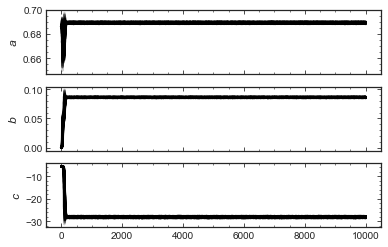

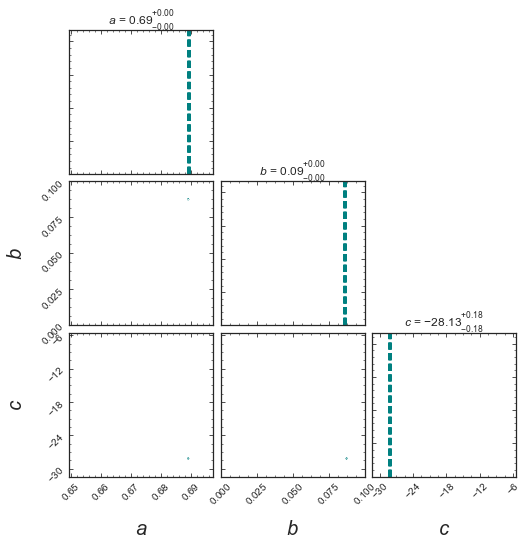

In [143]:
a_emcee, b_emcee, c_emcee = plane_emcee(vpeak_all, vshift_all, FWHM_all, ferr=None, N=1e4, burnin=1000,
                                        return_samples=False, abounds=[0,1], bbounds=[0,0.5], cbounds=[-200,200])

## Plot the plane

0.6893571040651323 0.08623275311246083 -28.138307984578688


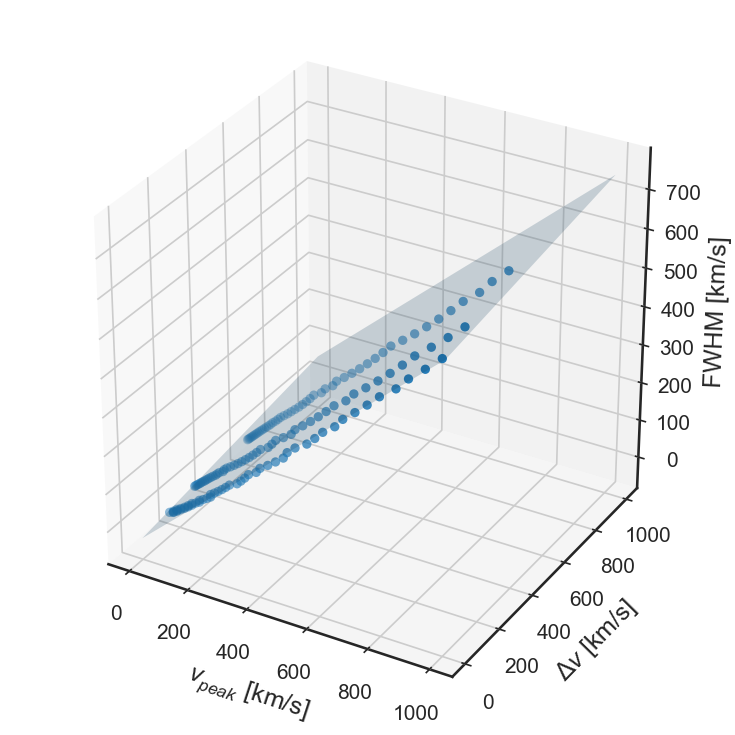

In [153]:
a, b, c = a_emcee[0], b_emcee[0], c_emcee[0]
print(a, b, c)

xs, ys, zs = vpeak_all, vshift_all, FWHM_all

fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, y``s, zs)

point  = np.array([0.0, 0.0, c])
normal = np.array(cross([1,0,a], [0,1,b]))
d = -point.dot(normal)
xx, yy = np.meshgrid([0,1000], [0, 1000])
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel(label_vpeak)
ax.set_ylabel(label_vshift)
ax.set_zlabel(label_FWHM)

fig.tight_layout()

# Can we infer $\Delta v$?

If we know FWHM and v_peak, can we infer $\Delta v$?

- Without noise, perfectly recover $\Delta v$

## Define probabilities

In [183]:
def FWHM_model(vpeak, vshift, a=0.6893571040651323, b=0.08623275311246083, c=-28.138307984578688):
    FWHM_mod = a*vpeak + b*vshift + c
    return FWHM_mod

def lnlikelihood(theta, vpeak, FWHM, sigma_FWHM):
    lnlike = (FWHM - FWHM_model(vpeak=vpeak, vshift=theta))**2./sigma_FWHM**2. - np.log(2.*np.pi*sigma_FWHM**2.)
    return -0.5*np.nansum(lnlike)

def lnprior(theta):
    if -100 < theta < 2000:
        return 0.
    else:
        return -np.inf
    
def lnposterior(theta, vpeak, FWHM, sigma_FWHM):
    return lnprior(theta) + lnlikelihood(theta, vpeak, FWHM, sigma_FWHM)

## set up inference

In [237]:
ndim, nwalkers = 1, 200
N = 1e3

# Model data
vshift_true = 100.

vpeak = np.linspace(0, 1000)
FWHM  = FWHM_model(vpeak, vshift_true)
sigma_FWHM = 1.*np.ones_like(FWHM)
FWHM_with_noise = FWHM + np.random.normal(sigma_FWHM)

# Starting guess
start = [vshift_true]
starting_guesses = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=[vpeak, FWHM_with_noise, sigma_FWHM])

In [238]:
width = 30
sampler.reset()
for i, (pos, prob, state) in enumerate(sampler.sample(starting_guesses, iterations=int(N))):
    n = int((width+1) * float(i) / N)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

print(("Mean acceptance fraction: {0:.3f}"
            .format(np.mean(sampler.acceptance_fraction))))

samples = sampler.chain[:, int(N/10):, :].reshape((-1, ndim))

[##############################]Mean acceptance fraction: 0.805


## Plots

112.27115963834186 110.63035210252137 113.91495545706918


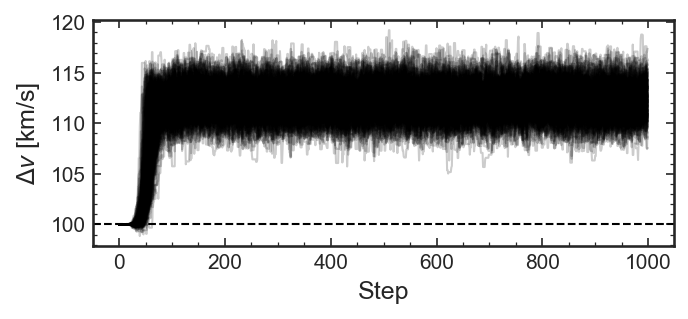

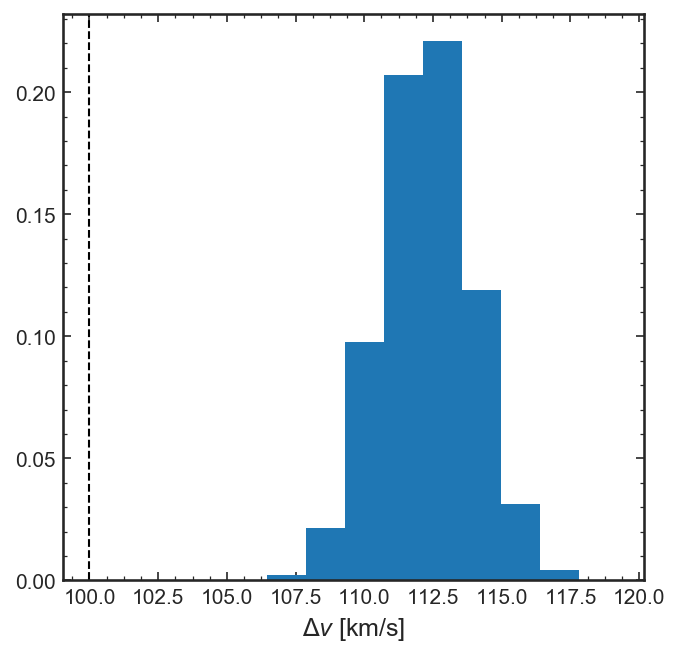

In [239]:
plt.figure(figsize=(5, 2), dpi=150)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2, lw=1)
plt.axhline(vshift_true, c='k', lw=1, ls='dashed')
plt.xlabel('Step')
plt.ylabel(label_vshift)

plt.figure(figsize=(5, 5), dpi=150)
plt.hist(samples, density=True)
plt.axvline(vshift_true, c='k', lw=1, ls='dashed')
plt.xlabel(label_vshift)

print(np.median(samples), np.percentile(samples, 16.), np.percentile(samples, 84.))

(100.0, 300.0)

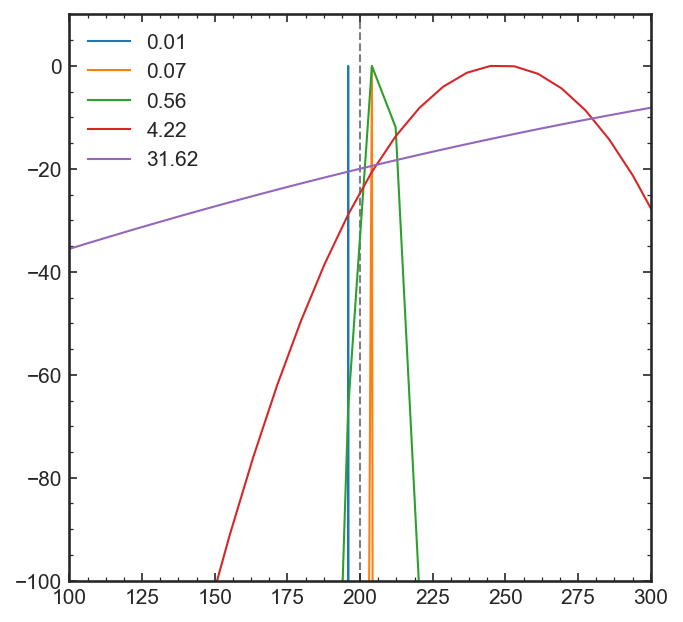

In [268]:
sigma = np.logspace(-2., 1.5, 5)
vshift_true = 200.
vshift_tab = np.linspace(0., 400)
plt.figure(figsize=(5, 5), dpi=150)

for s in sigma:
    
    FWHM_true  = FWHM_model(vpeak, vshift_true)
    
    s_all = s*np.ones(len(FWHM_true))
    FWHM_plus_noise = FWHM_true + np.random.normal(s_all)
    
    lnlike = np.array([lnlikelihood(theta=v, vpeak=vpeak, FWHM=FWHM_plus_noise, sigma_FWHM=s_all) for v in vshift_tab])
    lnlike -= lnlike.max()
    
    plt.plot(vshift_tab, lnlike, lw=1, label=np.round(s,2))
    
plt.legend()
    
plt.axvline(vshift_true, lw=1, c='0.5', zorder=0, ls='dashed')
plt.ylim(-100, 10)
plt.xlim(vshift_true-0.5*vshift_true, vshift_true+0.5*vshift_true)